### **Proyecto Time Series - Luis Alpizar**
- **Source**: 4Geeks
- **URL**: https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv

### Sistema de predicción de ventas

Queremos establecer el almacén de nuestra empresa en otra localización y necesitamos estimar el ritmo de las ventas, que desde la creación de la empresa ha ido en aumento, para los próximos meses, a fin de proveer el espacio que necesitaremos.

### Paso 0: Importar librerias

In [49]:
import logging
import pickle
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import (
    plot_acf,
    plot_pacf
)



from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
logger = logging.getLogger()
logger.setLevel(logging.ERROR)


### Paso 1: Carga del dataset

In [7]:
url = ('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [8]:
df_raw.sample(10,random_state=2025)

,date,sales
129,2023-01-10 17:10:08.079328,386.975810
86,2022-11-28 17:10:08.079328,277.371955
286,2023-06-16 17:10:08.079328,791.247802
223,2023-04-14 17:10:08.079328,631.855403
56,2022-10-29 17:10:08.079328,195.952976
128,2023-01-09 17:10:08.079328,385.167569
33,2022-10-06 17:10:08.079328,129.948022
58,2022-10-31 17:10:08.079328,199.055938
32,2022-10-05 17:10:08.079328,130.624314
7,2022-09-10 17:10:08.079328,67.765106


### Paso 2: Data preprocessing

In [14]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.replace("(", "").str.replace(")", "").str.replace(" ", "_")
df_baking.columns = df_baking.columns.str.lower()
df_baking["date"] = pd.to_datetime(df_baking.date)
df_baking = df_baking.set_index("date")
df_baking.info()
df_baking.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2022-09-03 17:10:08.079328 to 2023-09-03 17:10:08.079328
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633


In [15]:
df = df_baking.copy()
df.sample(10, random_state=2025)

,sales
date,
2023-01-10 17:10:08.079328,386.975810
2022-11-28 17:10:08.079328,277.371955
2023-06-16 17:10:08.079328,791.247802
2023-04-14 17:10:08.079328,631.855403
2022-10-29 17:10:08.079328,195.952976
2023-01-09 17:10:08.079328,385.167569
2022-10-06 17:10:08.079328,129.948022
2022-10-31 17:10:08.079328,199.055938
2022-10-05 17:10:08.079328,130.624314


In [29]:
df_train = df.iloc[:-12,:]
df_test = df.iloc[-12:,:]
df_train

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-08-18 17:10:08.079328,959.405128
2023-08-19 17:10:08.079328,958.666472
2023-08-20 17:10:08.079328,959.248269


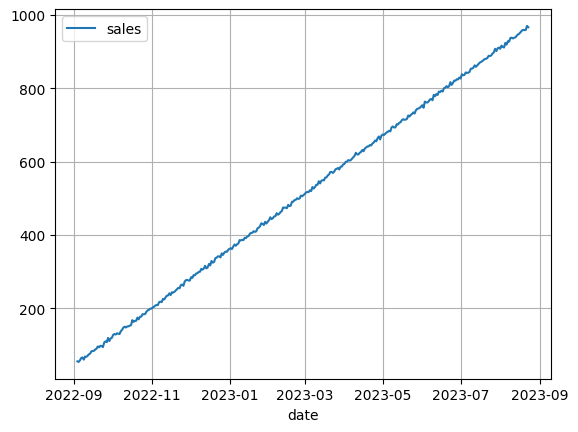

In [45]:
sns.lineplot(df_train)
plt.grid(True)
plt.show()

### Paso 3: Construye y analiza la serie temporal

In [19]:
def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

test_stationarity(df)

Dickey-Fuller test results:


,0
Test Statistic,0.545414
p-value,0.986190
#Lags Used,13.000000
Number of Observations Used,352.000000
Critical Value (1%),-3.449065
Critical Value (5%),-2.869786
Critical Value (10%),-2.571163


Prueba de Dickey-Fuller

- Test Statistic: 0.545414
- p-value: 0.986190 (mayor que 0.05, la serie no es Estacionaria)
- Lags Used: 13
- Number of Observations Used: 352
- Critical Values: Los valores críticos para los niveles de significancia del 1%, 5% y 10% son -3.449065, -2.869786 y -2.571163 respectivamente. El valor del Test Statistic es mayor que todos estos valores críticos

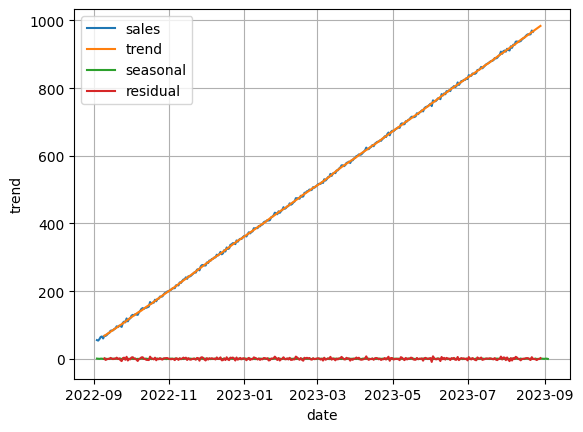

In [33]:
decomposition = seasonal_decompose(df['sales'],period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
sns.lineplot(df_train)
sns.lineplot(trend,label='trend')
sns.lineplot(seasonal,label='seasonal')
sns.lineplot(residual,label='residual')
plt.grid(True)
plt.show()

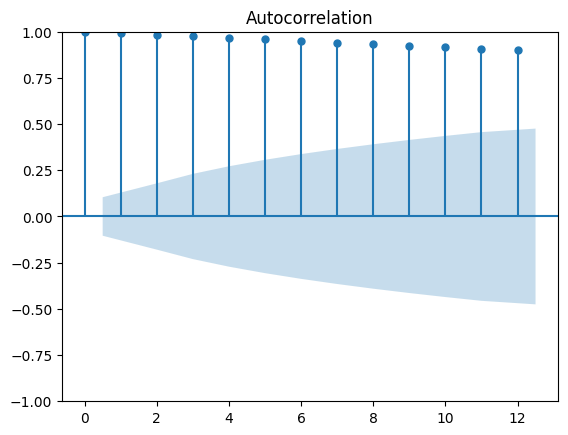

<Figure size 640x480 with 0 Axes>

In [44]:
plot_acf(df_train, lags=12)
plt.show()
plt.tight_layout()
plt.show()


    - ¿Cuál es el tensor de la serie temporal? La serie temporal se representa como un DataFrame.
    - ¿Cuál es la tendencia?
    - ¿Es estacionaria? No es estacionaria (p-value > 0.05).
    - ¿Existe variabilidad o presencia de ruido?  Hay variabilidad y posible ruido


### Paso 4: Machine Learning - ARIMA

In [50]:
arima = ARIMA(df['sales'],order=(2,1,2)) # order variables above 'd' (differencing),'p' (partial autocorrelation), 'q' (moving average) the goal in setting these is to make the P>|z| to be the lowest possible. find the lowest AIC or P>|z| for highest precision
ts_arima = arima.fit()
print(ts_arima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -922.666
Date:                Thu, 27 Mar 2025   AIC                           1855.332
Time:                        02:09:55   BIC                           1874.831
Sample:                    09-03-2022   HQIC                          1863.081
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9238      0.024     37.747      0.000       0.876       0.972
ar.L2          0.0762      0.024      3.114      0.002       0.028       0.124
ma.L1         -1.9201      0.024    -81.417      0.0

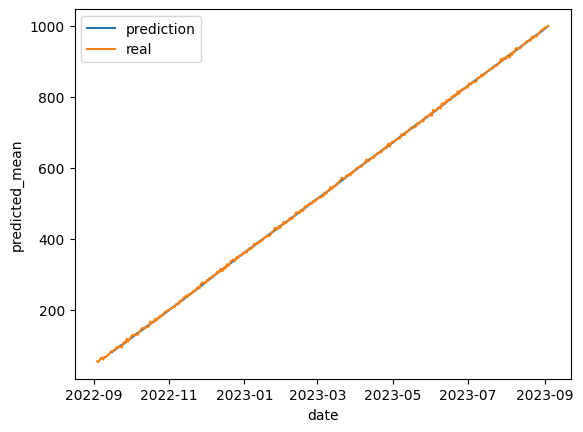

In [52]:
y_hat = ts_arima.predict(12) # argument 1, how many points into the future do you want to predict?
sns.lineplot(y_hat, label='prediction')
sns.lineplot(df['sales'],label='real')
plt.show()

### Paso 5: Guardar los modelos

In [53]:
with open("ts_arima.pkl", "wb") as ts_arima01:
    pickle.dump(ts_arima, ts_arima01)